In [102]:
import pandas as pd
import numpy as np
import mlens

from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint

from matplotlib.pyplot import show

from mlens.preprocessing import EnsembleTransformer
from mlens.model_selection import Evaluator
from mlens.metrics import make_scorer
from mlens.ensemble import SuperLearner

In [11]:
fake_real_df_clean = fake_real_df[['title','text','label']]
fake_real_df = pd.read_csv('./fake_or_real_news.csv')

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(fake_real_df_clean, fake_real_df_clean["label"]):
    strat_train_set = fake_real_df_clean.loc[train_index]
    strat_test_set = fake_real_df_clean.loc[test_index]

In [13]:
strat_fake_or_real_train = strat_train_set.copy()
strat_fake_or_real_test  = strat_test_set.copy()

In [14]:
X_train = strat_fake_or_real_train.copy().drop('label', 1)
y_train = strat_fake_or_real_train.copy()['label']
X_test  = strat_fake_or_real_test.copy().drop('label', 1)
y_test  = strat_fake_or_real_test.copy()['label']

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

def preprocessing(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]
    tokens = [word for word in tokens if len(word) >= 3]
    tokens = [word.lower() for word in tokens]
    lcStem = LancasterStemmer()
    tokens = [lcStem.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [16]:
X_train_text_list  = list(X_train['text'])
X_train_title_list = list(X_train['title'])
X_test_text_list   = list(X_test['text'])
X_test_title_list  = list(X_test['title'])

In [17]:
X_train_text_clean = [preprocessing(text) for text in X_train_text_list]
X_train_title_clean = [preprocessing(text) for text in X_train_title_list]
X_test_text_clean = [preprocessing(text) for text in X_test_text_list]
X_test_title_clean = [preprocessing(text) for text in X_test_title_list]

In [18]:
y_train_binary = [x=='REAL' for x in list(y_train)]
y_test_binary = [x=='REAL' for x in list(y_test)]

In [113]:
class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, X, y):
        result = super(MyTfidfVectorizer, self).fit_transform(X, y)
        result.sort_indices()
        return result

In [114]:
'''
The code above is all cleaning.
I separated the two features Text and title. 
You can join them into a df
if you want to use multiple features analysis.
Below is the actual machine learning that I have done
so far.
'''
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = MyTfidfVectorizer(min_df=2, ngram_range=(1,2), stop_words='english', strip_accents='unicode',norm=u'l2')

X_train_tfidf = vectorizer.fit_transform(X_train_text_clean, y_train_binary)

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

rfc = RandomForestClassifier() #.fit(X_train_tfidf, y_train_binary)
mnb = MultinomialNB()
abc = AdaBoostClassifier()
lac = LarsCV()

base_learners = [('rfc', rfc),
                 ('mnb', mnb),
                 ('abc', abc),
                ]


In [116]:
#type(X_train_tfidf.shape[0])
#len(base_learners)
P = np.zeros((X_train_tfidf.shape[0], len(base_learners)))
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est in base_learners:
    print('Processing: ', est_name)
    est.fit(X_train_tfidf, y_train_binary)
    p = est.predict(X_train_tfidf)
    P.loc[:, est_name] = p
    print("{0} mean absolute error: {1}".format(est_name, mean_absolute_error(y_train_binary, P[est_name])))

Processing:  rfc


/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


rfc mean absolute error: 0.005130228887134964
Processing:  mnb
mnb mean absolute error: 0.06610102604577743
Processing:  abc
abc mean absolute error: 0.09609313338595106


/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


In [117]:
P['Truth'] = y_train_binary
for est_name, est in base_learners:
    print(P[P[est_name] == P['Truth']][est_name].count()/len(P)*100)

99.4869771113
93.3898973954
90.3906866614


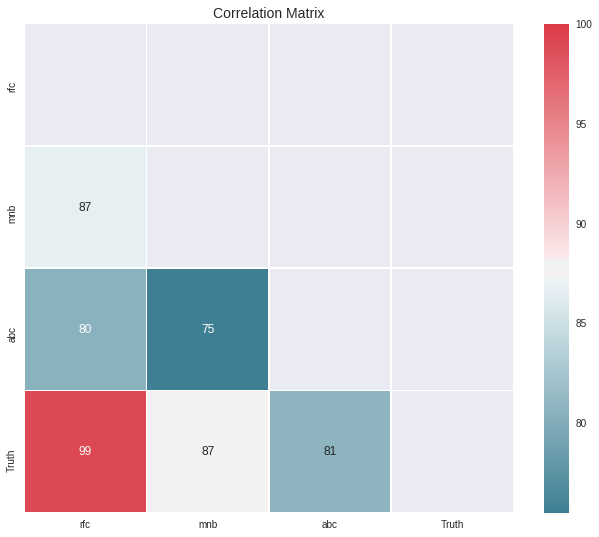

In [118]:
from mlens.visualization import corrmat
ax = corrmat(P.corr())
show()

In [119]:
param_dicts = {
    'rfc': 
        {'n_estimators': randint(5, 40),
         'max_features': ['sqrt', 'log2', None],
         'n_jobs': [-1]
        },
    'abc':
        {'n_estimators': randint(25, 50, 100),
         'learning_rate': uniform(0.1, 10),
        },
    'mnb':
        {'alpha': [0.026895783878784774],
         'class_prior': [None],
         'fit_prior': [False]
        }
}

In [120]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

evl = Evaluator(scorer, 
                cv=2,
                random_state=42,
                verbose=5
               )


meta_learners = [('rfc', rfc)]

in_layer = EnsembleTransformer()
in_layer.add('stack', base_learners)
preprocess = [in_layer]

In [121]:
ens = SuperLearner(verbose=5,
                   backend="threading")
ens.add(base_learners)
ens.add_meta(meta_learners)

SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None,
   estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            ...n_exception=True, scorer=None, verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

In [122]:
ens.fit(X_train_tfidf, y_train_binary)

Processing layers (2)



Fitting layer-1
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.0s remaining:    1.0s


Fit complete | 00:00:17



[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.5s finished
layer-1 Done | 00:00:17

Fitting layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00



SuperLearner(array_check=2, backend='threading', folds=2,
       layers=LayerContainer(backend='threading',
        layers=OrderedDict([('layer-1', Layer(cls='stack', cls_kwargs=None,
   estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            ...n_exception=True, scorer=None, verbose=5))]),
        n_jobs=-1, raise_on_exception=True, verbose=5),
       n_jobs=-1, raise_on_exception=True, random_state=None, scorer=None,
       shuffle=False, verbose=5)

In [123]:
X_test_tfidf = vectorizer.fit_transform(X_test_text_clean, y_test_binary)

In [131]:
print(X_test_tfidf.shape)
print(len(y_test_binary))
print(X_train_tfidf.shape)
print(len(y_train_binary))

(1267, 62200)
1267
(5068, 286760)
5068


In [124]:
ens_pred = ens.predict(X_test_tfidf)
print("Ensemble mean absolute error: {0}".format(mean_absolute_error(y_test_binary, ens_pred)))

Processing layers (2)



Predicting layer-1


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f75a5c8c0c0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/anthonyle/anaconda3/envs/deep_learning/lib...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/anthon.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f75a5c8c0c0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/anthonyle/anaconda3/envs/deep_learning/lib...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/anthon.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 15, 45, 31, 527030, tzinfo=datetime.timezone.utc), 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'55AD9960AF514B44A33856CD0CDB88E6']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 15, 45, 31, 527030, tzinfo=datetime.timezone.utc), 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'55AD9960AF514B44A33856CD0CDB88E6'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 15, 45, 31, 527030, tzinfo=datetime.timezone.utc), 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '7CEDC65BE2AF4064BADF387A91B23A59', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='ens_pred = ens.predict(X_test_tfidf)\nprint("Ense...at(mean_absolute_error(y_test_binary, ens_pred)))', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-124-4d700f445c49>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f755f937c88, executi..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7567666d20, file "<ipython-input-124-4d700f445c49>", line 1>
        result = <ExecutionResult object at 7f755f937c88, executi..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7567666d20, file "<ipython-input-124-4d700f445c49>", line 1>, result=<ExecutionResult object at 7f755f937c88, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7567666d20, file "<ipython-input-124-4d700f445c49>", line 1>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', 'nltk.download()', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', "y_train_binary = [x=='REAL' for x in list(y_trai...y_test_binary = [x=='REAL' for x in list(y_test)]", "'''\nThe code above is all cleaning.\nI separated ...fit_transform(X_train_text_clean, y_train_binary)", ...], 'LancasterStemmer': <class 'nltk.stem.lancaster.LancasterStemmer'>, 'LarsCV': <class 'sklearn.linear_model.least_angle.LarsCV'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'MyTfidfVectorizer': <class '__main__.MyTfidfVectorizer'>, 'Out': {9: True, 21: array([ 0.82955665,  0.82741617,  0.82329714,  0.81342547,  0.83119447]), 22: '\nIt is now up to you to use the data as you wish...ll going to work on improving the current model.\n', 29: <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 30: <1x286760 sparse matrix of type '<class 'numpy.f... stored elements in Compressed Sparse Row format>, 31: (5068, 286760), 32: 5068, 36: <class 'int'>, 37: 4, 38: <class 'int'>, ...}, 'P':         rfc    mnb    abc  Truth
0      True   T...lse  False  False  False

[5068 rows x 4 columns], ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', 'nltk.download()', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', "y_train_binary = [x=='REAL' for x in list(y_trai...y_test_binary = [x=='REAL' for x in list(y_test)]", "'''\nThe code above is all cleaning.\nI separated ...fit_transform(X_train_text_clean, y_train_binary)", ...], 'LancasterStemmer': <class 'nltk.stem.lancaster.LancasterStemmer'>, 'LarsCV': <class 'sklearn.linear_model.least_angle.LarsCV'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'MyTfidfVectorizer': <class '__main__.MyTfidfVectorizer'>, 'Out': {9: True, 21: array([ 0.82955665,  0.82741617,  0.82329714,  0.81342547,  0.83119447]), 22: '\nIt is now up to you to use the data as you wish...ll going to work on improving the current model.\n', 29: <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 30: <1x286760 sparse matrix of type '<class 'numpy.f... stored elements in Compressed Sparse Row format>, 31: (5068, 286760), 32: 5068, 36: <class 'int'>, 37: 4, 38: <class 'int'>, ...}, 'P':         rfc    mnb    abc  Truth
0      True   T...lse  False  False  False

[5068 rows x 4 columns], ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/mnt/Linux-Extra/home-extra/Anthony.Le/Projects/fake_news/<ipython-input-124-4d700f445c49> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 ens_pred = ens.predict(X_test_tfidf)
      7 print("Ensemble mean absolute error: {0}".format(mean_absolute_error(y_test_binary, ens_pred)))
      8 
      9 
     10 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in predict(self=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>)
    739         if self.shuffle:
    740             r = check_random_state(self.random_state)
    741             idx = r.permutation(X.shape[0])
    742             X = X[idx]
    743 
--> 744         y = self.layers.predict(X)
        y = undefined
        self.layers.predict = <bound method LayerContainer.predict of LayerCon...  n_jobs=-1, raise_on_exception=True, verbose=5)>
        X = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
    745 
    746         if y.shape[1] == 1:
    747             # The meta estimator is treated as a layer and thus a prediction
    748             # matrix with shape [n_samples, 1] is created. Ravel before return

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in predict(self=LayerContainer(backend='threading',
        laye...   n_jobs=-1, raise_on_exception=True, verbose=5), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, *args=(), **kwargs={})
    262         Returns
    263         -------
    264         X_pred : array-like of shape = [n_samples, n_fitted_estimators]
    265             predictions from final layer.
    266         """
--> 267         return self._predict(X, 'predict', *args, **kwargs)
        self._predict = <bound method LayerContainer._predict of LayerCo...  n_jobs=-1, raise_on_exception=True, verbose=5)>
        X = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        args = ()
        kwargs = {}
    268 
    269     def transform(self, X=None, *args, **kwargs):
    270         """Generic method for reproducing predictions of the ``fit`` call.
    271 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in _predict(self=LayerContainer(backend='threading',
        laye...   n_jobs=-1, raise_on_exception=True, verbose=5), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, job='predict', *args=(), **kwargs={})
    315         processor = ParallelProcessing(self)
    316         processor.initialize(job, X, *args, **kwargs)
    317 
    318         # Predict with ensemble
    319         try:
--> 320             processor.process()
        processor.process = <bound method ParallelProcessing.process of <mlens.parallel.manager.ParallelProcessing object>>
    321 
    322             preds = processor.get_preds()
    323 
    324             if self.verbose:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/manager.py in process(self=<mlens.parallel.manager.ParallelProcessing object>)
    213                       mmap_mode='w+',
    214                       verbose=self.layers.verbose,
    215                       backend=self.layers.backend) as parallel:
    216 
    217             for n, lyr in enumerate(self.layers.layers.values()):
--> 218                 self._partial_process(n, lyr, parallel)
        self._partial_process = <bound method ParallelProcessing._partial_proces...lens.parallel.manager.ParallelProcessing object>>
        n = 0
        lyr = Layer(cls='stack', cls_kwargs=None,
   estimator... raise_on_exception=True, scorer=None, verbose=5)
        parallel = Parallel(n_jobs=-1)
    219 
    220         self.__fitted__ = 1
    221 
    222     def get_preds(self, n=-1, dtype=np.float, order='C'):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/manager.py in _partial_process(self=<mlens.parallel.manager.ParallelProcessing object>, n=0, lyr=Layer(cls='stack', cls_kwargs=None,
   estimator... raise_on_exception=True, scorer=None, verbose=5), parallel=Parallel(n_jobs=-1))
    303         if 'X' in fargs:
    304             kwargs['X'] = self.job.P[n]
    305         if 'P' in fargs:
    306             kwargs['P'] = self.job.P[n + 1]
    307 
--> 308         f(**kwargs)
        f = <bound method BaseEstimator.predict of <mlens.parallel.stack.Stacker object>>
        kwargs = {'P': memmap([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), 'X': <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, 'parallel': Parallel(n_jobs=-1)}
    309 
    310 
    311 ###############################################################################
    312 class ParallelEvaluation(object):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/estimation.py in predict(self=<mlens.parallel.stack.Stacker object>, X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, P=memmap([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), parallel=Parallel(n_jobs=-1))
    224                                       xtest=X,
    225                                       pred=P,
    226                                       col=col,
    227                                       name=self.name,
    228                                       attr=pred_method)
--> 229                  for case, (inst_name, est, (_, col)) in ests)
        ests = [(None, ('rfc', RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), (None, 0))), (None, ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), (None, 1))), (None, ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), (None, 2)))]
    230 
    231         if self.verbose:
    232             print_time(t0, '%s Done' % self.name, file=printout)
    233 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseEstimator.predict.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jun 25 08:45:31 2017
PID: 16426Python 3.6.1: /home/anthonyle/anaconda3/envs/deep_learning/bin/python
...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in __call__(self=<mlens.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function predict_est>, (), {'attr': 'predict', 'case': None, 'col': 0, 'est': RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), 'inst_name': 'rfc', 'name': 'layer-1', 'pred': memmap([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), 'tr_list': [], 'xtest': <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function predict_est>
        args = ()
        kwargs = {'attr': 'predict', 'case': None, 'col': 0, 'est': RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), 'inst_name': 'rfc', 'name': 'layer-1', 'pred': memmap([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), 'tr_list': [], 'xtest': <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/estimation.py in predict_est(case=None, tr_list=[], inst_name='rfc', est=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), xtest=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, pred=memmap([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), col=0, name='layer-1', attr='predict')
    402 
    403     # Predict into memmap
    404     # Here, we coerce errors on failed predictions - all predictors that
    405     # survive into the estimators_ attribute of a layer should be able to
    406     # predict, otherwise the subsequent layer will get corrupt input.
--> 407     p = getattr(est, attr)(xtest)
        p = undefined
        est = RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False)
        attr = 'predict'
        xtest = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
    408 
    409     if len(p.shape) == 1:
    410         pred[:, col] = p
    411     else:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in predict(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>)
    529         Returns
    530         -------
    531         y : array of shape = [n_samples] or [n_samples, n_outputs]
    532             The predicted classes.
    533         """
--> 534         proba = self.predict_proba(X)
        proba = undefined
        self.predict_proba = <bound method ForestClassifier.predict_proba of ...e=None,
            verbose=0, warm_start=False)>
        X = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
    535 
    536         if self.n_outputs_ == 1:
    537             return self.classes_.take(np.argmax(proba, axis=1), axis=0)
    538 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in predict_proba(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>)
    568             such arrays if n_outputs > 1.
    569             The class probabilities of the input samples. The order of the
    570             classes corresponds to that in the attribute `classes_`.
    571         """
    572         # Check data
--> 573         X = self._validate_X_predict(X)
        X = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
        self._validate_X_predict = <bound method BaseForest._validate_X_predict of ...e=None,
            verbose=0, warm_start=False)>
    574 
    575         # Assign chunk of trees to jobs
    576         n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)
    577 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _validate_X_predict(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>)
    350         """Validate X whenever one tries to predict, apply, predict_proba"""
    351         if self.estimators_ is None or len(self.estimators_) == 0:
    352             raise NotFittedError("Estimator not fitted, "
    353                                  "call `fit` before exploiting the model.")
    354 
--> 355         return self.estimators_[0]._validate_X_predict(X, check_input=True)
        self.estimators_._validate_X_predict = undefined
        X = <1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>
    356 
    357     @property
    358     def feature_importances_(self):
    359         """Return the feature importances (the higher, the more important the

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/tree/tree.py in _validate_X_predict(self=DecisionTreeClassifier(class_weight=None, criter...rt=False, random_state=30958129, splitter='best'), X=<1267x62200 sparse matrix of type '<class 'numpy... stored elements in Compressed Sparse Row format>, check_input=True)
    371         n_features = X.shape[1]
    372         if self.n_features_ != n_features:
    373             raise ValueError("Number of features of the model must "
    374                              "match the input. Model n_features is %s and "
    375                              "input n_features is %s "
--> 376                              % (self.n_features_, n_features))
        self.n_features_ = 286760
        n_features = 62200
    377 
    378         return X
    379 
    380     def predict(self, X, check_input=True):

ValueError: Number of features of the model must match the input. Model n_features is 286760 and input n_features is 62200 
___________________________________________________________________________

In [106]:
from sklearn.model_selection import cross_val_score
cross_val_score(ens, X_train_tfidf, y_train_binary, cv=5, scoring="accuracy")

Processing layers (2)



Fitting layer-1
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.7s remaining:    0.9s


Fit complete | 00:00:19



[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   19.1s finished
layer-1 Done | 00:00:19

Fitting layer-2
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
layer-2 Done | 00:00:00



Processing layers (2)



Predicting layer-1


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f75a5c8c0c0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/anthonyle/anaconda3/envs/deep_learning/lib...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/anthon.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f75a5c8c0c0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/anthonyle/anaconda3/envs/deep_learning/lib...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/anthon.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 9, 30, 44, 209328, tzinfo=datetime.timezone.utc), 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'55AD9960AF514B44A33856CD0CDB88E6']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 9, 30, 44, 209328, tzinfo=datetime.timezone.utc), 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'55AD9960AF514B44A33856CD0CDB88E6'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 25, 9, 30, 44, 209328, tzinfo=datetime.timezone.utc), 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'session': '55AD9960AF514B44A33856CD0CDB88E6', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '94F9EAB6938145C09C5F4C0A42C6ABC9', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import cross_val_sc..._tfidf, y_train_binary, cv=5, scoring="accuracy")', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Expr object>], cell_name='<ipython-input-106-3a7f44104b84>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f755940dcc0, executi..._before_exec=None error_in_exec=None result=None>)
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])
   2807                 code = compiler(mod, cell_name, "single")
-> 2808                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7566b519c0, file "<ipython-input-106-3a7f44104b84>", line 2>
        result = <ExecutionResult object at 7f755940dcc0, executi..._before_exec=None error_in_exec=None result=None>
   2809                     return True
   2810 
   2811             # Flush softspace
   2812             if softspace(sys.stdout, 0):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7566b519c0, file "<ipython-input-106-3a7f44104b84>", line 2>, result=<ExecutionResult object at 7f755940dcc0, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7566b519c0, file "<ipython-input-106-3a7f44104b84>", line 2>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', 'nltk.download()', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', "y_train_binary = [x=='REAL' for x in list(y_trai...y_test_binary = [x=='REAL' for x in list(y_test)]", "'''\nThe code above is all cleaning.\nI separated ...fit_transform(X_train_text_clean, y_train_binary)", ...], 'LancasterStemmer': <class 'nltk.stem.lancaster.LancasterStemmer'>, 'LarsCV': <class 'sklearn.linear_model.least_angle.LarsCV'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {9: True, 21: array([ 0.82955665,  0.82741617,  0.82329714,  0.81342547,  0.83119447]), 22: '\nIt is now up to you to use the data as you wish...ll going to work on improving the current model.\n', 29: <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 30: <1x286760 sparse matrix of type '<class 'numpy.f... stored elements in Compressed Sparse Row format>, 31: (5068, 286760), 32: 5068, 36: <class 'int'>, 37: 4, 38: <class 'int'>, ...}, 'P':         rfc    mnb    abc  Truth
0      True   T...lse  False  False  False

[5068 rows x 4 columns], 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'In': ['', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', 'nltk.download()', "import pandas as pd\nfake_real_df = pd.read_csv('./fake_or_real_news.csv')", "fake_real_df_clean = fake_real_df[['title','text','label']]", 'from sklearn.model_selection import StratifiedSh...rat_test_set = fake_real_df_clean.loc[test_index]', 'strat_fake_or_real_train = strat_train_set.copy()\nstrat_fake_or_real_test  = strat_test_set.copy()', "X_train = strat_fake_or_real_train.copy().drop('...y_test  = strat_fake_or_real_test.copy()['label']", "import nltk\nfrom nltk.corpus import stopwords\nfr...t = ' '.join(tokens)\n    return preprocessed_text", "X_train_text_list  = list(X_train['text'])\nX_tra...ext'])\nX_test_title_list  = list(X_test['title'])", 'X_train_text_clean = [preprocessing(text) for te...reprocessing(text) for text in X_test_title_list]', "y_train_binary = [x=='REAL' for x in list(y_trai...y_test_binary = [x=='REAL' for x in list(y_test)]", "'''\nThe code above is all cleaning.\nI separated ...fit_transform(X_train_text_clean, y_train_binary)", ...], 'LancasterStemmer': <class 'nltk.stem.lancaster.LancasterStemmer'>, 'LarsCV': <class 'sklearn.linear_model.least_angle.LarsCV'>, 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'Out': {9: True, 21: array([ 0.82955665,  0.82741617,  0.82329714,  0.81342547,  0.83119447]), 22: '\nIt is now up to you to use the data as you wish...ll going to work on improving the current model.\n', 29: <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 30: <1x286760 sparse matrix of type '<class 'numpy.f... stored elements in Compressed Sparse Row format>, 31: (5068, 286760), 32: 5068, 36: <class 'int'>, 37: 4, 38: <class 'int'>, ...}, 'P':         rfc    mnb    abc  Truth
0      True   T...lse  False  False  False

[5068 rows x 4 columns], 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/mnt/Linux-Extra/home-extra/Anthony.Le/Projects/fake_news/<ipython-input-106-3a7f44104b84> in <module>()
      1 
----> 2 
      3 
      4 
      5 from sklearn.model_selection import cross_val_score
      6 cross_val_score(ens, X_train_tfidf, y_train_binary, cv=5, scoring="accuracy")
      7 
      8 
      9 
     10 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X=<5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=[True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], groups=None, scoring='accuracy', cv=KFold(n_splits=5, random_state=None, shuffle=False), n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    135     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    136                         pre_dispatch=pre_dispatch)
    137     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
    138                                               train, test, verbose, None,
    139                                               fit_params)
--> 140                       for train, test in cv_iter)
        cv_iter = [(array([1014, 1015, 1016, ..., 5065, 5066, 5067]), array([   0,    1,    2, ..., 1011, 1012, 1013])), (array([   0,    1,    2, ..., 5065, 5066, 5067]), array([1014, 1015, 1016, ..., 2025, 2026, 2027])), (array([   0,    1,    2, ..., 5065, 5066, 5067]), array([2028, 2029, 2030, ..., 3039, 3040, 3041])), (array([   0,    1,    2, ..., 5065, 5066, 5067]), array([3042, 3043, 3044, ..., 4052, 4053, 4054])), (array([   0,    1,    2, ..., 4052, 4053, 4054]), array([4055, 4056, 4057, ..., 5065, 5066, 5067]))]
    141     return np.array(scores)[:, 0]
    142 
    143 
    144 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object cross_val_score.<locals>.<genexpr>>)
    753         self.n_completed_tasks = 0
    754         try:
    755             # Only set self._iterating to True if at least a batch
    756             # was dispatched. In particular this covers the edge
    757             # case of Parallel used with an exhausted iterator.
--> 758             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object cross_val_score.<locals>.<genexpr>>
    759                 self._iterating = True
    760             else:
    761                 self._iterating = False
    762 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object cross_val_score.<locals>.<genexpr>>)
    603             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    604             if len(tasks) == 0:
    605                 # No more tasks available in the iterator: tell caller to stop.
    606                 return False
    607             else:
--> 608                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    609                 return True
    610 
    611     def _print(self, msg, msg_args):
    612         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    566         self.n_dispatched_tasks += len(batch)
    567         self.n_dispatched_batches += 1
    568 
    569         dispatch_timestamp = time.time()
    570         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 571         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    572         self._jobs.append(job)
    573 
    574     def dispatch_next(self):
    575         """Dispatch more data for parallel processing

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    104             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    105         return 1
    106 
    107     def apply_async(self, func, callback=None):
    108         """Schedule a func to be run"""
--> 109         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    110         if callback:
    111             callback(result)
    112         return result
    113 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    321 
    322 class ImmediateResult(object):
    323     def __init__(self, batch):
    324         # Don't delay the application, to avoid keeping the input
    325         # arguments in memory
--> 326         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    327 
    328     def get(self):
    329         return self.results
    330 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, [True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], make_scorer(accuracy_score), array([1014, 1015, 1016, ..., 5065, 5066, 5067]), array([   0,    1,    2, ..., 1011, 1012, 1013]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), <5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, [True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], make_scorer(accuracy_score), array([1014, 1015, 1016, ..., 5065, 5066, 5067]), array([   0,    1,    2, ..., 1011, 1012, 1013]), 0, None, None)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X=<5068x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y=[True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], scorer=make_scorer(accuracy_score), train=array([1014, 1015, 1016, ..., 5065, 5066, 5067]), test=array([   0,    1,    2, ..., 1011, 1012, 1013]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5)
        X_test = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y_test = [True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...]
        scorer = make_scorer(accuracy_score)
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _score(estimator=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X_test=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y_test=[True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], scorer=make_scorer(accuracy_score))
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(accuracy_score)
        estimator = SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5)
        X_test = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        y_test = [True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...]
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/scorer.py in __call__(self=make_scorer(accuracy_score), estimator=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, y_true=[True, False, False, False, False, False, False, False, True, True, True, False, True, False, True, False, True, True, False, False, ...], sample_weight=None)
     86         score : float
     87             Score function applied to prediction of estimator on X.
     88         """
     89         super(_PredictScorer, self).__call__(estimator, X, y_true,
     90                                              sample_weight=sample_weight)
---> 91         y_pred = estimator.predict(X)
        y_pred = undefined
        estimator.predict = <bound method BaseEnsemble.predict of SuperLearn...e, scorer=None,
       shuffle=False, verbose=5)>
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
     92         if sample_weight is not None:
     93             return self._sign * self._score_func(y_true, y_pred,
     94                                                  sample_weight=sample_weight,
     95                                                  **self._kwargs)

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in predict(self=SuperLearner(array_check=2, backend='threading',...ne, scorer=None,
       shuffle=False, verbose=5), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
    739         if self.shuffle:
    740             r = check_random_state(self.random_state)
    741             idx = r.permutation(X.shape[0])
    742             X = X[idx]
    743 
--> 744         y = self.layers.predict(X)
        y = undefined
        self.layers.predict = <bound method LayerContainer.predict of LayerCon...  n_jobs=-1, raise_on_exception=True, verbose=5)>
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
    745 
    746         if y.shape[1] == 1:
    747             # The meta estimator is treated as a layer and thus a prediction
    748             # matrix with shape [n_samples, 1] is created. Ravel before return

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in predict(self=LayerContainer(backend='threading',
        laye...   n_jobs=-1, raise_on_exception=True, verbose=5), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, *args=(), **kwargs={})
    262         Returns
    263         -------
    264         X_pred : array-like of shape = [n_samples, n_fitted_estimators]
    265             predictions from final layer.
    266         """
--> 267         return self._predict(X, 'predict', *args, **kwargs)
        self._predict = <bound method LayerContainer._predict of LayerCo...  n_jobs=-1, raise_on_exception=True, verbose=5)>
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        args = ()
        kwargs = {}
    268 
    269     def transform(self, X=None, *args, **kwargs):
    270         """Generic method for reproducing predictions of the ``fit`` call.
    271 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/ensemble/base.py in _predict(self=LayerContainer(backend='threading',
        laye...   n_jobs=-1, raise_on_exception=True, verbose=5), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, job='predict', *args=(), **kwargs={})
    315         processor = ParallelProcessing(self)
    316         processor.initialize(job, X, *args, **kwargs)
    317 
    318         # Predict with ensemble
    319         try:
--> 320             processor.process()
        processor.process = <bound method ParallelProcessing.process of <mlens.parallel.manager.ParallelProcessing object>>
    321 
    322             preds = processor.get_preds()
    323 
    324             if self.verbose:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/manager.py in process(self=<mlens.parallel.manager.ParallelProcessing object>)
    213                       mmap_mode='w+',
    214                       verbose=self.layers.verbose,
    215                       backend=self.layers.backend) as parallel:
    216 
    217             for n, lyr in enumerate(self.layers.layers.values()):
--> 218                 self._partial_process(n, lyr, parallel)
        self._partial_process = <bound method ParallelProcessing._partial_proces...lens.parallel.manager.ParallelProcessing object>>
        n = 0
        lyr = Layer(cls='stack', cls_kwargs=None,
   estimator... raise_on_exception=True, scorer=None, verbose=5)
        parallel = Parallel(n_jobs=-1)
    219 
    220         self.__fitted__ = 1
    221 
    222     def get_preds(self, n=-1, dtype=np.float, order='C'):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/manager.py in _partial_process(self=<mlens.parallel.manager.ParallelProcessing object>, n=0, lyr=Layer(cls='stack', cls_kwargs=None,
   estimator... raise_on_exception=True, scorer=None, verbose=5), parallel=Parallel(n_jobs=-1))
    303         if 'X' in fargs:
    304             kwargs['X'] = self.job.P[n]
    305         if 'P' in fargs:
    306             kwargs['P'] = self.job.P[n + 1]
    307 
--> 308         f(**kwargs)
        f = <bound method BaseEstimator.predict of <mlens.parallel.stack.Stacker object>>
        kwargs = {'P': memmap([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]]), 'X': <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, 'parallel': Parallel(n_jobs=-1)}
    309 
    310 
    311 ###############################################################################
    312 class ParallelEvaluation(object):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/estimation.py in predict(self=<mlens.parallel.stack.Stacker object>, X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, P=memmap([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]]), parallel=Parallel(n_jobs=-1))
    224                                       xtest=X,
    225                                       pred=P,
    226                                       col=col,
    227                                       name=self.name,
    228                                       attr=pred_method)
--> 229                  for case, (inst_name, est, (_, col)) in ests)
        ests = [(None, ('rfc', RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), (None, 0))), (None, ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), (None, 1))), (None, ('abc', AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), (None, 2)))]
    230 
    231         if self.verbose:
    232             print_time(t0, '%s Done' % self.name, file=printout)
    233 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseEstimator.predict.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Jun 25 02:31:03 2017
PID: 16426Python 3.6.1: /home/anthonyle/anaconda3/envs/deep_learning/bin/python
...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in __call__(self=<mlens.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function predict_est>, (), {'attr': 'predict', 'case': None, 'col': 0, 'est': RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), 'inst_name': 'rfc', 'name': 'layer-1', 'pred': memmap([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]]), 'tr_list': [], 'xtest': <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function predict_est>
        args = ()
        kwargs = {'attr': 'predict', 'case': None, 'col': 0, 'est': RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), 'inst_name': 'rfc', 'name': 'layer-1', 'pred': memmap([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]]), 'tr_list': [], 'xtest': <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/mlens/parallel/estimation.py in predict_est(case=None, tr_list=[], inst_name='rfc', est=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), xtest=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, pred=memmap([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.],...
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]]), col=0, name='layer-1', attr='predict')
    402 
    403     # Predict into memmap
    404     # Here, we coerce errors on failed predictions - all predictors that
    405     # survive into the estimators_ attribute of a layer should be able to
    406     # predict, otherwise the subsequent layer will get corrupt input.
--> 407     p = getattr(est, attr)(xtest)
        p = undefined
        est = RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False)
        attr = 'predict'
        xtest = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
    408 
    409     if len(p.shape) == 1:
    410         pred[:, col] = p
    411     else:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in predict(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
    529         Returns
    530         -------
    531         y : array of shape = [n_samples] or [n_samples, n_outputs]
    532             The predicted classes.
    533         """
--> 534         proba = self.predict_proba(X)
        proba = undefined
        self.predict_proba = <bound method ForestClassifier.predict_proba of ...e=None,
            verbose=0, warm_start=False)>
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
    535 
    536         if self.n_outputs_ == 1:
    537             return self.classes_.take(np.argmax(proba, axis=1), axis=0)
    538 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in predict_proba(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
    568             such arrays if n_outputs > 1.
    569             The class probabilities of the input samples. The order of the
    570             classes corresponds to that in the attribute `classes_`.
    571         """
    572         # Check data
--> 573         X = self._validate_X_predict(X)
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        self._validate_X_predict = <bound method BaseForest._validate_X_predict of ...e=None,
            verbose=0, warm_start=False)>
    574 
    575         # Assign chunk of trees to jobs
    576         n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)
    577 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _validate_X_predict(self=RandomForestClassifier(bootstrap=True, class_wei...te=None,
            verbose=0, warm_start=False), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
    350         """Validate X whenever one tries to predict, apply, predict_proba"""
    351         if self.estimators_ is None or len(self.estimators_) == 0:
    352             raise NotFittedError("Estimator not fitted, "
    353                                  "call `fit` before exploiting the model.")
    354 
--> 355         return self.estimators_[0]._validate_X_predict(X, check_input=True)
        self.estimators_._validate_X_predict = undefined
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
    356 
    357     @property
    358     def feature_importances_(self):
    359         """Return the feature importances (the higher, the more important the

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/tree/tree.py in _validate_X_predict(self=DecisionTreeClassifier(class_weight=None, criter...t=False, random_state=537424915, splitter='best'), X=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, check_input=True)
    360         if self.tree_ is None:
    361             raise NotFittedError("Estimator not fitted, "
    362                                  "call `fit` before exploiting the model.")
    363 
    364         if check_input:
--> 365             X = check_array(X, dtype=DTYPE, accept_sparse="csr")
        X = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
    366             if issparse(X) and (X.indices.dtype != np.intc or
    367                                 X.indptr.dtype != np.intc):
    368                 raise ValueError("No support for np.int64 index based "
    369                                  "sparse matrices")

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, accept_sparse=['csr'], dtype=<class 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    375         estimator_name = "Estimator"
    376     context = " by %s" % estimator_name if estimator is not None else ""
    377 
    378     if sp.issparse(array):
    379         array = _ensure_sparse_format(array, accept_sparse, dtype, copy,
--> 380                                       force_all_finite)
        force_all_finite = True
    381     else:
    382         array = np.array(array, dtype=dtype, order=order, copy=copy)
    383 
    384         if ensure_2d:

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/utils/validation.py in _ensure_sparse_format(spmatrix=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, accept_sparse=['csr'], dtype=<class 'numpy.float32'>, copy=False, force_all_finite=True)
    253         spmatrix = spmatrix.asformat(accept_sparse[0])
    254         changed_format = True
    255 
    256     if dtype != spmatrix.dtype:
    257         # convert dtype
--> 258         spmatrix = spmatrix.astype(dtype)
        spmatrix = <1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>
        spmatrix.astype = <bound method _data_matrix.astype of <1014x28676...stored elements in Compressed Sparse Row format>>
        dtype = <class 'numpy.float32'>
    259     elif copy and not changed_format:
    260         # force copy
    261         spmatrix = spmatrix.copy()
    262 

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/scipy/sparse/data.py in astype(self=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>, t=<class 'numpy.float32'>)
     63             return self
     64         else:
     65             return NotImplemented
     66 
     67     def astype(self, t):
---> 68         return self._with_data(self._deduped_data().astype(t))
        self._with_data = <bound method _cs_matrix._with_data of <1014x286...stored elements in Compressed Sparse Row format>>
        self._deduped_data.astype = undefined
        t = <class 'numpy.float32'>
     69 
     70     astype.__doc__ = spmatrix.astype.__doc__
     71 
     72     def conj(self):

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/scipy/sparse/data.py in _deduped_data(self=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
     29         self.data.dtype = newtype
     30     dtype = property(fget=_get_dtype, fset=_set_dtype)
     31 
     32     def _deduped_data(self):
     33         if hasattr(self, 'sum_duplicates'):
---> 34             self.sum_duplicates()
        self.sum_duplicates = <bound method _cs_matrix.sum_duplicates of <1014...stored elements in Compressed Sparse Row format>>
     35         return self.data
     36 
     37     def __abs__(self):
     38         return self._with_data(abs(self._deduped_data()))

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/scipy/sparse/compressed.py in sum_duplicates(self=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
   1011 
   1012         The is an *in place* operation
   1013         """
   1014         if self.has_canonical_format:
   1015             return
-> 1016         self.sort_indices()
        self.sort_indices = <bound method _cs_matrix.sort_indices of <1014x2...stored elements in Compressed Sparse Row format>>
   1017 
   1018         M, N = self._swap(self.shape)
   1019         _sparsetools.csr_sum_duplicates(M, N, self.indptr, self.indices,
   1020                                         self.data)

...........................................................................
/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/scipy/sparse/compressed.py in sort_indices(self=<1014x286760 sparse matrix of type '<class 'nump... stored elements in Compressed Sparse Row format>)
   1057         """Sort the indices of this matrix *in place*
   1058         """
   1059 
   1060         if not self.has_sorted_indices:
   1061             _sparsetools.csr_sort_indices(len(self.indptr) - 1, self.indptr,
-> 1062                                           self.indices, self.data)
        self.indices = memmap([285386, 285009, 284390, ...,   1862,   1712,   1709], dtype=int32)
        self.data = memmap([ 0.04089954,  0.01047909,  0.05310395, ...,  0.03177006,
        0.02322263,  0.01355832])
   1063             self.has_sorted_indices = True
   1064 
   1065     def prune(self):
   1066         """Remove empty space after all non-zero elements.

ValueError: UPDATEIFCOPY base is read-only
___________________________________________________________________________

There is some error in this module. Given that it is rather late, I may just have to predict based on majority vote.

In [69]:
mean_absolute_error(y_train_binary, P['rfc'])

/home/anthonyle/anaconda3/envs/deep_learning/lib/python3.6/site-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


0.006314127861089187

In [93]:
help(uniform)

Help on uniform_gen in module scipy.stats._continuous_distns object:

class uniform_gen(scipy.stats._distn_infrastructure.rv_continuous)
 |  A uniform continuous random variable.
 |  
 |  This distribution is constant between `loc` and ``loc + scale``.
 |  
 |  %(before_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      uniform_gen
 |      scipy.stats._distn_infrastructure.rv_continuous
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods inherited from scipy.stats._distn_infrastructure.rv_continuous:
 |  
 |  __init__(self, momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, extradoc=None, seed=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, x, *args, **kwds)
 |      Cumulative distribution function of the given RV.
 |      
 |      Parameters
 |      ----------
 |      x : array_like
 |          quantiles
 |      arg1, arg2, arg3,... : 